In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet


In [2]:
from __future__ import absolute_import, division, print_function

import math
import os
import cv2
import albumentations
import joblib
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models, transforms
from tqdm import tqdm

In [3]:
train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
data0 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_0.parquet')
data1 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_1.parquet')
data2 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_2.parquet')
data3 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_3.parquet')

data_full = pd.concat([data0, data1, data2, data3], ignore_index=True)
#data_full = joblib.load("data.pkl")
del data0, data1, data2, data3
device = "cuda"


In [4]:
class GraphemeDataset(Dataset):
    def __init__(self, df, label, _type='train'):
        self.df = df
        self.label = label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.df.iloc[idx][1:].values.astype(np.float).reshape(137,236)
        return image, label2, label1, label3


In [5]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion, 168)
        self.fc2 = nn.Linear(512 * block.expansion, 11)
        self.fc3 = nn.Linear(512 * block.expansion, 7)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        p = self.fc1(x)
        q = self.fc2(x)
        r = self.fc3(x)
        return p, q, r


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [6]:
model = resnet34().cuda()
optimizer = optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.05)
criterion = nn.CrossEntropyLoss()
batch_size = 32

In [7]:
epochs = 100
model.train()
losses = []
accs = []
reduced_index = train.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(
    lambda x: x.sample(5)).image_id.values
reduced_train = train.loc[train.image_id.isin(reduced_index)]
reduced_data = data_full.loc[data_full.image_id.isin(reduced_index)]
train_image = GraphemeDataset(reduced_data, reduced_train)
valid_size = 0.2
num_train = len(train_image)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(
    train_image, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_image, batch_size=64,
                                          sampler=valid_sampler)
valid_loss_min = np.Inf  # track change in validation loss
model.train()
for epoch in range(epochs):

    print('epochs {}/{} '.format(epoch+1, epochs))
    running_loss = 0.0
    running_acc = 0.0
    running_loss1 = 0.0
    running_acc1 = 0.0
    for idx, (inputs, labels1, labels2, labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)

        optimizer.zero_grad()
        outputs1, outputs2, outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)
        running_loss += loss1+loss2+loss3
        running_acc += (outputs1.argmax(1) == labels1).float().mean()
        running_acc += (outputs2.argmax(1) == labels2).float().mean()
        running_acc += (outputs3.argmax(1) == labels3).float().mean()
        (loss1+loss2+loss3).backward()
        optimizer.step()

    # scheduler.step()
    model.eval()
    for idx, (inputs, labels1, labels2, labels3) in tqdm(enumerate(validloader), total=len(validloader)):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)

        with torch.no_grad():

            outputs1, outputs2, outputs3 = model(inputs.unsqueeze(1).float())
            loss1 = criterion(outputs1, labels1)
            loss2 = criterion(outputs2, labels2)
            loss3 = criterion(outputs3, labels3)
        running_loss1 += loss1+loss2+loss3
        running_acc1 += (outputs1.argmax(1) == labels1).float().mean()
        running_acc1 += (outputs2.argmax(1) == labels2).float().mean()
        running_acc1 += (outputs3.argmax(1) == labels3).float().mean()

    train_loss = running_loss/len(train_loader)
    valid_loss = running_loss1/len(train_loader)

    print('train acc : {:.4f}%'.format(running_acc/(len(train_loader)*3)))
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('valid acc : {:.4f}%'.format(running_acc1/(len(train_loader)*3)))
    print('valid loss : {:.4f}'.format(running_loss1/len(train_loader)))
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'validation50epoch.pt')
        valid_loss_min = valid_loss
    torch.save(model.state_dict(), 'novalidation50epoch.pt')

torch.save(model.state_dict(), '50resnet34full.pth')


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 1/100 


100%|██████████| 21/21 [00:50<00:00,  2.40s/it]


train acc : 0.4281%
train loss : 7.0667
valid acc : 0.0378%
valid loss : 1.0337
Validation loss decreased (inf --> 1.033661).  Saving model ...


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 2/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2809%
train loss : 8.5288
valid acc : 0.0355%
valid loss : 1.0464
epochs 3/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2805%
train loss : 8.0834
valid acc : 0.0364%
valid loss : 1.0474
epochs 4/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2850%
train loss : 8.0729
valid acc : 0.0362%
valid loss : 1.0466
epochs 5/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2824%
train loss : 8.0658
valid acc : 0.0357%
valid loss : 1.0444
epochs 6/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2856%
train loss : 8.0601
valid acc : 0.0368%
valid loss : 1.0440
epochs 7/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0585
valid acc : 0.0364%
valid loss : 1.0443
epochs 8/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2859%
train loss : 8.0545
valid acc : 0.0363%
valid loss : 1.0420
epochs 9/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2831%
train loss : 8.0521
valid acc : 0.0367%
valid loss : 1.0412
epochs 10/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2862%
train loss : 8.0487
valid acc : 0.0360%
valid loss : 1.0461
epochs 11/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2858%
train loss : 8.0504
valid acc : 0.0363%
valid loss : 1.0432
epochs 12/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2850%
train loss : 8.0495
valid acc : 0.0362%
valid loss : 1.0410
epochs 13/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0456
valid acc : 0.0358%
valid loss : 1.0454
epochs 14/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2859%
train loss : 8.0464
valid acc : 0.0364%
valid loss : 1.0404
epochs 15/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2852%
train loss : 8.0456
valid acc : 0.0366%
valid loss : 1.0398
epochs 16/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2862%
train loss : 8.0452
valid acc : 0.0359%
valid loss : 1.0424
epochs 17/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2849%
train loss : 8.0453
valid acc : 0.0359%
valid loss : 1.0414
epochs 18/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0449
valid acc : 0.0363%
valid loss : 1.0419
epochs 19/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2841%
train loss : 8.0456
valid acc : 0.0367%
valid loss : 1.0403
epochs 20/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2853%
train loss : 8.0426
valid acc : 0.0365%
valid loss : 1.0428
epochs 21/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2854%
train loss : 8.0428
valid acc : 0.0358%
valid loss : 1.0426
epochs 22/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2852%
train loss : 8.0428
valid acc : 0.0367%
valid loss : 1.0404
epochs 23/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0415
valid acc : 0.0363%
valid loss : 1.0410
epochs 24/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2864%
train loss : 8.0389
valid acc : 0.0360%
valid loss : 1.0429
epochs 25/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2852%
train loss : 8.0394
valid acc : 0.0367%
valid loss : 1.0421
epochs 26/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0395
valid acc : 0.0364%
valid loss : 1.0412
epochs 27/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0414
valid acc : 0.0369%
valid loss : 1.0409
epochs 28/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2872%
train loss : 8.0396
valid acc : 0.0367%
valid loss : 1.0411
epochs 29/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2847%
train loss : 8.0383
valid acc : 0.0372%
valid loss : 1.0412
epochs 30/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2879%
train loss : 8.0412
valid acc : 0.0364%
valid loss : 1.0435
epochs 31/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0390
valid acc : 0.0364%
valid loss : 1.0413
epochs 32/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0375
valid acc : 0.0367%
valid loss : 1.0420
epochs 33/100 


100%|██████████| 21/21 [00:49<00:00,  2.37s/it]


train acc : 0.2861%
train loss : 8.0372
valid acc : 0.0361%
valid loss : 1.0428


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 34/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0385
valid acc : 0.0365%
valid loss : 1.0418
epochs 35/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0388
valid acc : 0.0358%
valid loss : 1.0440
epochs 36/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2834%
train loss : 8.0380
valid acc : 0.0365%
valid loss : 1.0443
epochs 37/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0369
valid acc : 0.0369%
valid loss : 1.0421
epochs 38/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0377
valid acc : 0.0366%
valid loss : 1.0419
epochs 39/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2859%
train loss : 8.0383
valid acc : 0.0362%
valid loss : 1.0465
epochs 40/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0354
valid acc : 0.0361%
valid loss : 1.0409
epochs 41/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0359
valid acc : 0.0367%
valid loss : 1.0400
epochs 42/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0377
valid acc : 0.0363%
valid loss : 1.0426
epochs 43/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2872%
train loss : 8.0369
valid acc : 0.0364%
valid loss : 1.0426
epochs 44/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0360
valid acc : 0.0360%
valid loss : 1.0419
epochs 45/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2874%
train loss : 8.0355
valid acc : 0.0362%
valid loss : 1.0436
epochs 46/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0353
valid acc : 0.0365%
valid loss : 1.0455
epochs 47/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2862%
train loss : 8.0369
valid acc : 0.0365%
valid loss : 1.0430
epochs 48/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2872%
train loss : 8.0356
valid acc : 0.0365%
valid loss : 1.0434
epochs 49/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2840%
train loss : 8.0338
valid acc : 0.0362%
valid loss : 1.0424
epochs 50/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2873%
train loss : 8.0342
valid acc : 0.0363%
valid loss : 1.0427
epochs 51/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2860%
train loss : 8.0355
valid acc : 0.0366%
valid loss : 1.0429
epochs 52/100 


100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


train acc : 0.2857%
train loss : 8.0328
valid acc : 0.0360%
valid loss : 1.0422


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 53/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2860%
train loss : 8.0341
valid acc : 0.0366%
valid loss : 1.0415
epochs 54/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0333
valid acc : 0.0363%
valid loss : 1.0438
epochs 55/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0345
valid acc : 0.0359%
valid loss : 1.0431
epochs 56/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2875%
train loss : 8.0337
valid acc : 0.0360%
valid loss : 1.0432
epochs 57/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2872%
train loss : 8.0315
valid acc : 0.0371%
valid loss : 1.0408
epochs 58/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0333
valid acc : 0.0360%
valid loss : 1.0436
epochs 59/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2868%
train loss : 8.0356
valid acc : 0.0364%
valid loss : 1.0412
epochs 60/100 


100%|██████████| 21/21 [00:47<00:00,  2.28s/it]


train acc : 0.2863%
train loss : 8.0354
valid acc : 0.0365%
valid loss : 1.0409


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 61/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2873%
train loss : 8.0341
valid acc : 0.0365%
valid loss : 1.0416
epochs 62/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2857%
train loss : 8.0348
valid acc : 0.0357%
valid loss : 1.0436
epochs 63/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2868%
train loss : 8.0338
valid acc : 0.0357%
valid loss : 1.0440
epochs 64/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0351
valid acc : 0.0369%
valid loss : 1.0424
epochs 65/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0333
valid acc : 0.0363%
valid loss : 1.0431
epochs 66/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2864%
train loss : 8.0320
valid acc : 0.0361%
valid loss : 1.0426
epochs 67/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0320
valid acc : 0.0361%
valid loss : 1.0420
epochs 68/100 


100%|██████████| 21/21 [00:49<00:00,  2.33s/it]


train acc : 0.2865%
train loss : 8.0346
valid acc : 0.0361%
valid loss : 1.0415


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 69/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2864%
train loss : 8.0324
valid acc : 0.0369%
valid loss : 1.0415
epochs 70/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2877%
train loss : 8.0316
valid acc : 0.0358%
valid loss : 1.0430
epochs 71/100 


100%|██████████| 21/21 [00:52<00:00,  2.52s/it]


train acc : 0.2853%
train loss : 8.0304
valid acc : 0.0357%
valid loss : 1.0425


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 72/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2862%
train loss : 8.0342
valid acc : 0.0367%
valid loss : 1.0408
epochs 73/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2869%
train loss : 8.0306
valid acc : 0.0364%
valid loss : 1.0414
epochs 74/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0334
valid acc : 0.0363%
valid loss : 1.0408
epochs 75/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2862%
train loss : 8.0328
valid acc : 0.0367%
valid loss : 1.0408
epochs 76/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2868%
train loss : 8.0334
valid acc : 0.0364%
valid loss : 1.0419
epochs 77/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2869%
train loss : 8.0319
valid acc : 0.0361%
valid loss : 1.0417
epochs 78/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2873%
train loss : 8.0334
valid acc : 0.0362%
valid loss : 1.0428
epochs 79/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0308
valid acc : 0.0363%
valid loss : 1.0418
epochs 80/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2865%
train loss : 8.0311
valid acc : 0.0366%
valid loss : 1.0428
epochs 81/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2869%
train loss : 8.0318
valid acc : 0.0361%
valid loss : 1.0396
epochs 82/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0318
valid acc : 0.0365%
valid loss : 1.0395
epochs 83/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0333
valid acc : 0.0361%
valid loss : 1.0420
epochs 84/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2869%
train loss : 8.0315
valid acc : 0.0363%
valid loss : 1.0412
epochs 85/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2868%
train loss : 8.0321
valid acc : 0.0361%
valid loss : 1.0418
epochs 86/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2881%
train loss : 8.0314
valid acc : 0.0356%
valid loss : 1.0432
epochs 87/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0315
valid acc : 0.0367%
valid loss : 1.0425
epochs 88/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0331
valid acc : 0.0362%
valid loss : 1.0415
epochs 89/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2876%
train loss : 8.0303
valid acc : 0.0365%
valid loss : 1.0416
epochs 90/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2875%
train loss : 8.0329
valid acc : 0.0364%
valid loss : 1.0406
epochs 91/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2868%
train loss : 8.0310
valid acc : 0.0365%
valid loss : 1.0443
epochs 92/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2871%
train loss : 8.0305
valid acc : 0.0369%
valid loss : 1.0413
epochs 93/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2863%
train loss : 8.0312
valid acc : 0.0361%
valid loss : 1.0422
epochs 94/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0310
valid acc : 0.0364%
valid loss : 1.0429
epochs 95/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0304
valid acc : 0.0360%
valid loss : 1.0399
epochs 96/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2867%
train loss : 8.0304
valid acc : 0.0362%
valid loss : 1.0399
epochs 97/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2870%
train loss : 8.0292
valid acc : 0.0361%
valid loss : 1.0437
epochs 98/100 


  0%|          | 0/162 [00:00<?, ?it/s]

train acc : 0.2861%
train loss : 8.0316
valid acc : 0.0363%
valid loss : 1.0420
epochs 99/100 


100%|██████████| 21/21 [00:50<00:00,  2.41s/it]


train acc : 0.2867%
train loss : 8.0311
valid acc : 0.0359%
valid loss : 1.0440


  0%|          | 0/162 [00:00<?, ?it/s]

epochs 100/100 


100%|██████████| 21/21 [00:51<00:00,  2.44s/it]


train acc : 0.2867%
train loss : 8.0324
valid acc : 0.0361%
valid loss : 1.0426


Text(0.5, 1.0, 'acc')

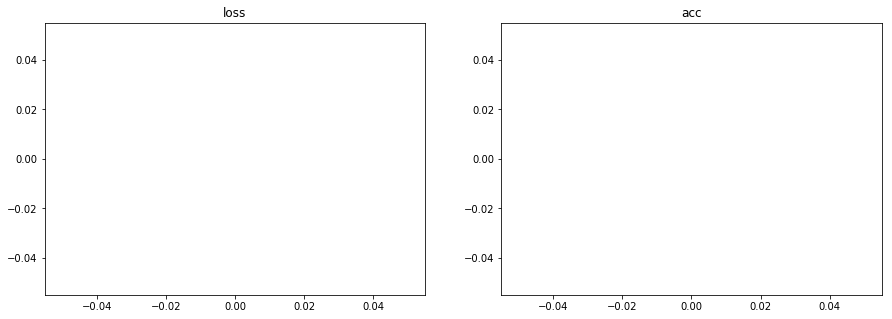

In [8]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('loss')
ax[1].plot(accs)
ax[1].set_title('acc')

In [9]:
test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')


In [10]:
class GraphemeDataset(Dataset):
    def __init__(self,df,_type='train'):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image = self.df.iloc[idx][1:].values.reshape(64,64).astype(float)
        return image

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet34(pretrained=False).to(device)
model.load_state_dict(torch.load('./novalidation50epoch.pt'))

<All keys matched successfully>

In [12]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [13]:
%%time
model.eval()
test_data = ['test_image_data_0.parquet','test_image_data_1.parquet','test_image_data_2.parquet','test_image_data_3.parquet']
predictions = []
batch_size=1
for fname in test_data:
    data = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/{fname}')
    data = Resize(data)
    test_image = GraphemeDataset(data)
    test_loader = torch.utils.data.DataLoader(test_image,batch_size=1,shuffle=False)
    with torch.no_grad():
        for idx, (inputs) in tqdm(enumerate(test_loader),total=len(test_loader)):
            inputs.to(device)
            
            outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float().cuda())
            predictions.append(outputs3.argmax(1).cpu().detach().numpy())
            predictions.append(outputs2.argmax(1).cpu().detach().numpy())
            predictions.append(outputs1.argmax(1).cpu().detach().numpy())

100%|██████████| 3/3 [00:00<00:00, 48.41it/s]

CPU times: user 12.4 s, sys: 1.54 s, total: 13.9 s
Wall time: 11.3 s


In [14]:
submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')


In [15]:
submission.target = np.hstack(predictions)
submission.head(10)

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,107
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0
5,Test_1_vowel_diacritic,107
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,0
8,Test_2_vowel_diacritic,107
9,Test_3_consonant_diacritic,0


In [16]:
submission.to_csv('submission.csv',index=False)
